In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os
import torch.utils.data as data
import torch.nn as nn
import glob
# from torchsummary import summary
from torchinfo import summary
from tqdm import trange

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2")
print(device)
current_device = device #torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
print(f"Current GPU assigned: {current_device}, Name: {device_name}")

cuda:2
Current GPU assigned: cuda:2, Name: NVIDIA A100-SXM4-80GB


Consider it a prediction task only, but for now, use only pressure and/or wind speed inputs to start with, because they are the indicators of horizontal movement of air pollution. Multiple inputs can go as multiple channels of images similar to RGB. Output should be only P25 for now. You can train on some 10 days of data and predict on next 10 days of data.

In [3]:
def get_latitudes():
    lat_start= 76.8499984741211
    lat_step=0.009999999776482582

    latitudes=[]

    for i in range(80):
        latitudes.append(lat_start+i*lat_step)
    
    latitudes.reverse()

    return latitudes

def get_longitudes():
    long_start= 28.200000762939453
    long_step=0.009999999776482582

    longitudes=[]

    for i in range(80):
        longitudes.append(long_start+i*long_step)
    
    # longitudes.reverse()

    return longitudes

latitudes=get_latitudes()
longitudes=get_longitudes()

def create_plot(data,hour,var_name):
    # print(data[var_name].shape) #shape (120, 1, 80, 80)
    p10_hour=data[var_name]['TSTEP'==hour] # shape (1, 80, 80)
    p10_hour=p10_hour[0,:,:] # shape (80, 80)
    plt.imshow(p10_hour)
    plt.title(f'{var_name} at hour '+str(hour))
    # plt.colorbar()

    # only show every latitude and longitude of end points
    # round to 2 decimal places
    top=latitudes[0]
    top=round(top,2) 
    bottom=latitudes[-1]
    bottom=round(bottom,2)
    left=longitudes[0]
    left=round(left,2)
    right=longitudes[-1]
    right=round(right,2)

    plt.xticks([0,79],[left,right])
    plt.xlabel('Longitude')
    plt.yticks([0,79],[top,bottom])
    plt.ylabel('Latitude')
    # plt.savefig(f'plots/120/{var_name}_{day}.png')
    # plt.close()

# 96 hr files

In [50]:
data_96 = xr.open_dataset('data/camxmet2d.delhi.20230717.96hours.nc')
data_96_df = data_96.to_dataframe().reset_index()

In [51]:
data_96

<xarray.Dataset>
Dimensions:     (TSTEP: 96, VAR: 14, DATE-TIME: 2, LAY: 1, ROW: 80, COL: 80)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables: (12/15)
    TFLAG       (TSTEP, VAR, DATE-TIME) int32 2023198 0 ... 2023201 230000
    TSURF_K     (TSTEP, LAY, ROW, COL) float32 302.3 302.3 302.3 ... 300.6 301.2
    SNOWEW_M    (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SNOWAGE_HR  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PRATE_MMpH  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLOUD_OD    (TSTEP, LAY, ROW, COL) float32 62.24 61.67 61.1 ... 37.1 36.78
    ...          ...
    SWSFC_WpM2  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SOLM_M3pM3  (TSTEP, LAY, ROW, COL) float32 0.3131 0.3114 ... 0.3278 0.3292
    CLDTOP_KM   (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CAPE        (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PBL_WRF_M   (TSTEP, LAY, ROW, COL) float32 17.21 17.21 17.21 ... 94.4 120.0
    PBL_YSU_M   (TSTEP, LAY, ROW, COL) float32 17.21 17.21 17.21 ... 64.43 94.71
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023198
    CTIME:          73941
    WDATE:          2023198
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [52]:
data_96_df

,TSTEP,VAR,DATE-TIME,LAY,ROW,COL,TFLAG,TSURF_K,SNOWEW_M,SNOWAGE_HR,...,CLOUD_OD,U10_MpS,V10_MpS,T2_K,SWSFC_WpM2,SOLM_M3pM3,CLDTOP_KM,CAPE,PBL_WRF_M,PBL_YSU_M
0,0,0,0,0,0,0,2023198,302.314636,0.0,0.0,...,62.239326,1.630373,0.148722,302.571838,0.0,0.313128,0.0,0.0,17.212452,17.212452
1,0,0,0,0,0,1,2023198,302.312042,0.0,0.0,...,61.671093,1.585281,0.158011,302.584351,0.0,0.311416,0.0,0.0,17.212652,17.212652
2,0,0,0,0,0,2,2023198,302.309479,0.0,0.0,...,61.102859,1.540188,0.167299,302.596832,0.0,0.309703,0.0,0.0,17.212852,17.212852
3,0,0,0,0,0,3,2023198,302.306885,0.0,0.0,...,60.534630,1.495095,0.176587,302.609344,0.0,0.307990,0.0,0.0,17.213055,17.213055
4,0,0,0,0,0,4,2023198,302.303558,0.0,0.0,...,59.912636,1.450304,0.184773,302.621948,0.0,0.306286,0.0,0.0,17.213356,17.213356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17203195,95,13,1,0,79,75,230000,298.979095,0.0,0.0,...,37.972748,0.600130,-1.341342,299.389465,0.0,0.324286,0.0,0.0,26.661556,17.082989
17203196,95,13,1,0,79,76,230000,299.372223,0.0,0.0,...,37.747482,0.658128,-1.301898,299.638062,0.0,0.324927,0.0,0.0,43.123440,17.094244
17203197,95,13,1,0,79,77,230000,299.967468,0.0,0.0,...,37.423786,0.732263,-1.252025,300.018402,0.0,0.326345,0.0,0.0,68.759804,17.112419
17203198,95,13,1,0,79,78,230000,300.562744,0.0,0.0,...,37.100090,0.806398,-1.202152,300.398743,0.0,0.327763,0.0,0.0,94.396065,64.426094


In [53]:
data_96_df.columns

Index(['TSTEP', 'VAR', 'DATE-TIME', 'LAY', 'ROW', 'COL', 'TFLAG', 'TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M'],
      dtype='object')

In [56]:
data_96['U10_MpS'] #shape (96, 1, 80, 80)

<xarray.DataArray 'U10_MpS' (TSTEP: 96, LAY: 1, ROW: 80, COL: 80)>
array([[[[ 1.630373, ..., -0.434344],
         ...,
         [-0.544169, ..., -2.070899]]],


       ...,


       [[[ 0.569056, ...,  0.423629],
         ...,
         [ 0.774855, ...,  0.880477]]]], dtype=float32)
Dimensions without coordinates: TSTEP, LAY, ROW, COL
Attributes:
    long_name:  U10_MpS         
    units:      ppmV            
    var_desc:   VARIABLE U10_MpS                                             ...

In [57]:
data_96['U10_MpS'].shape , data_96['U10_MpS']['TSTEP'==0].shape, data_96['U10_MpS']['TSTEP'==0][0].shape

((96, 1, 80, 80), (1, 80, 80), (80, 80))

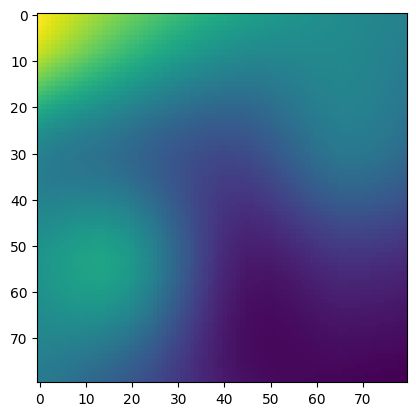

In [10]:
plt.imshow(data_96['U10_MpS']['TSTEP'==0][0]) #shape (80, 80)

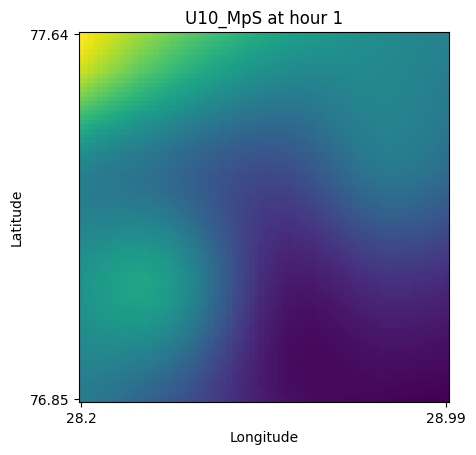

In [11]:
create_plot(data = data_96, hour = 1, var_name = 'U10_MpS')

# 120 hr files

In [12]:
data_120 = xr.open_dataset('data/camx120hr_merged_20230717.nc')
data_120_df = data_120.to_dataframe().reset_index() 

In [ ]:
data_120 

<xarray.Dataset>
Dimensions:  (TSTEP: 120, LAY: 1, ROW: 80, COL: 80, VAR: 9, DATE-TIME: 2)
Dimensions without coordinates: TSTEP, LAY, ROW, COL, VAR, DATE-TIME
Data variables:
    P10      (TSTEP, LAY, ROW, COL) float32 23.86 23.86 24.07 ... 10.1 10.1
    P25      (TSTEP, LAY, ROW, COL) float32 19.24 19.24 19.62 ... 9.63 9.63
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 2023197 0 2023197 ... 2023201 230000
Attributes: (12/34)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023197
    CTIME:          83911
    WDATE:          2023197
    ...             ...
    GDNAM:          ????????????????
    UPNAM:          CAMXMETOU       
    VAR-LIST:       P10             P25             
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:        Mon Jul 17 08:45:22 2023: ncrcat camxout.2023.07.16.nc ca...
    NCO:            netCDF Operators version 4.9.1 (Homepage = http://nco.sf....

In [ ]:
data_120_df

,TSTEP,LAY,ROW,COL,VAR,DATE-TIME,P10,P25,TFLAG
0,0,0,0,0,0,0,23.857107,19.240587,2023197
1,0,0,0,0,0,1,23.857107,19.240587,0
2,0,0,0,0,1,0,23.857107,19.240587,2023197
3,0,0,0,0,1,1,23.857107,19.240587,0
4,0,0,0,0,2,0,23.857107,19.240587,2023197
...,...,...,...,...,...,...,...,...,...
13823995,119,0,79,79,6,1,10.097546,9.629862,230000
13823996,119,0,79,79,7,0,10.097546,9.629862,2023201
13823997,119,0,79,79,7,1,10.097546,9.629862,230000
13823998,119,0,79,79,8,0,10.097546,9.629862,2023201


In [ ]:
data_120_df.describe()

,TSTEP,LAY,ROW,COL,VAR,DATE-TIME,P10,P25,TFLAG
count,1.382400e+07,13824000.0,1.382400e+07,1.382400e+07,1.382400e+07,13824000.0,1.382400e+07,1.382400e+07,1.382400e+07
mean,5.950000e+01,0.0,3.950000e+01,3.950000e+01,4.000000e+00,0.5,4.101470e+01,2.856279e+01,1.069100e+06
std,3.463981e+01,0.0,2.309221e+01,2.309221e+01,2.581989e+00,0.5,2.361775e+01,1.582030e+01,9.553543e+05
min,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.111396e+00,8.114247e-01,0.000000e+00
25%,2.975000e+01,0.0,1.975000e+01,1.975000e+01,2.000000e+00,0.0,2.546643e+01,1.880392e+01,1.175000e+05
50%,5.950000e+01,0.0,3.950000e+01,3.950000e+01,4.000000e+00,0.5,3.590978e+01,2.589731e+01,1.126598e+06
75%,8.925000e+01,0.0,5.925000e+01,5.925000e+01,6.000000e+00,1.0,5.103806e+01,3.433007e+01,2.023199e+06
max,1.190000e+02,0.0,7.900000e+01,7.900000e+01,8.000000e+00,1.0,6.492913e+02,6.130998e+02,2.023201e+06


In [ ]:
data_120['COL']

<xarray.DataArray 'COL' (COL: 80)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79])
Dimensions without coordinates: COL

In [ ]:
data_120['P10'] #shape (120, 1, 80, 80)

<xarray.DataArray 'P10' (TSTEP: 120, LAY: 1, ROW: 80, COL: 80)>
array([[[[23.857107, ..., 28.82367 ],
         ...,
         [34.902046, ..., 18.506985]]],


       ...,


       [[[38.434433, ..., 22.536842],
         ...,
         [20.921093, ..., 10.097546]]]], dtype=float32)
Dimensions without coordinates: TSTEP, LAY, ROW, COL
Attributes:
    long_name:  CPRM            
    units:      micrograms/m**3 
    var_desc:   VARIABLE CPRM                                                ...

In [ ]:
data_120['P10']['TSTEP'==1]# shape 1x80x80

<xarray.DataArray 'P10' (LAY: 1, ROW: 80, COL: 80)>
array([[[23.857107, 23.857107, ..., 28.82367 , 28.82367 ],
        [23.857107, 23.857107, ..., 28.82367 , 28.82367 ],
        ...,
        [34.902046, 34.902046, ..., 18.506985, 18.506985],
        [34.902046, 34.902046, ..., 18.506985, 18.506985]]], dtype=float32)
Dimensions without coordinates: LAY, ROW, COL
Attributes:
    long_name:  CPRM            
    units:      micrograms/m**3 
    var_desc:   VARIABLE CPRM                                                ...

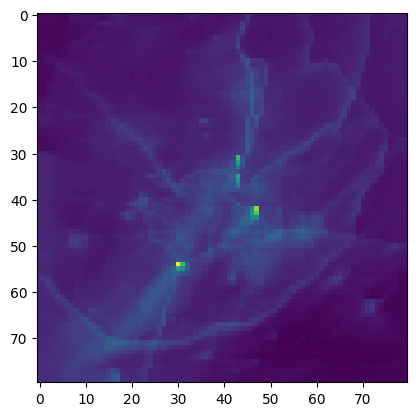

In [ ]:
data_120['P10']['TSTEP'==1][0] # shape 80x80
plt.imshow(data_120['P25']['TSTEP'==1][0])#, vmin=0, vmax=100)

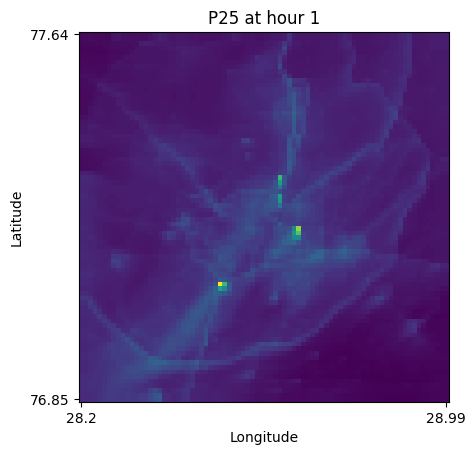

In [ ]:
create_plot(data_120,1,'P25') 

# Constructing data

In [4]:
# Define the folder path where your files are located
folder_path = 'data/'

# Use glob to retrieve all netCDF files in the folder
file_pattern = 'camx120*.nc'
files_120 = glob.glob(folder_path + file_pattern)
# files_120

file_pattern = '*96hours.nc'
files_96 = glob.glob(folder_path + file_pattern)
# files_96

In [5]:
print(len(files_120))
files_120.sort()
print(files_120[0], files_120[-1]) 

70
data/camx120hr_merged_20230717.nc data/camx120hr_merged_20230924.nc


In [6]:
print(len(files_96))
files_96.sort()
print(files_96[0], files_96[-1]) 

69
data/camxmet2d.delhi.20230717.96hours.nc data/camxmet2d.delhi.20230924.96hours.nc


camx96hr has 20230808 day file missing. so removing it from camx120hr as well 'data/camx120hr_merged_20230808.nc'

In [7]:
files_120.remove('data/camx120hr_merged_20230808.nc')
len(files_120)

69

camx96hr file contains 96 hrs for days [0,1,2,3]

camx120hr file contains 120 hrs for days [-1,0,1,2,3]

We need current day data from each file to avoid redundancy. So we will take 0-23 hrs from camx96hr and 24-47hrs from camx120hr

In [8]:
def get_data(target_var_96_list, target_var_120_list):
    X = []
    y = []
 
    for target_var_96 in target_var_96_list:
        column = []
        for i in files_96:
            data_96 = xr.open_dataset(i)
            for j in range(0,24):
                variable96 = data_96[target_var_96]['TSTEP'==j]
                column.append(variable96)
        column = np.array(column)
        # print(column.shape) # (69*24, 1, 80, 80)
        X.append(column)
    X = np.array(X)
    X = np.concatenate([X[i] for i in range(X.shape[0])], axis=1)
    print('X shape ',X.shape)
    for target_var_120 in target_var_120_list:
        column = []
        for i in files_120:
            data_120 = xr.open_dataset(i)
            for j in range(0,24):
                variable120 = data_120[target_var_120]['TSTEP'==24+j]
                column.append(variable120)
        column = np.array(column)
        # print(column.shape) # (69*24, 1, 80, 80)
        y.append(column)
    y = np.array(y)
    y = np.concatenate([y[i] for i in range(y.shape[0])], axis=1)
    print('y shape', y.shape)
    return X,y

In [9]:
target_var_96_list =['TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

X shape  (1656, 14, 80, 80)
y shape (1656, 2, 80, 80)


In [10]:
X[:, 0, :,:].shape # selecting first channel

(1656, 80, 80)

# model defination

## Simple autoencoder

In [11]:
class Autoencoder_MLP(nn.Module):
    def __init__(self):
        super(Autoencoder_MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()  # Flatten the 2D input matrix
        self.fc1 = nn.Linear(80*80, 1024)  # Fully connected layer 1
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1024)  # Fully connected layer 2
        self.fc4 = nn.Linear(1024, 80*80)  # Fully connected layer 2
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        # Flatten the input
        x = self.flatten(x)
        
        # Forward pass through the fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)

        # Reshape the output to match the 2D matrix size
        x = x.view(-1, 80, 80)
        
        return x

In [12]:
summary(Autoencoder_MLP(), input_size=(1, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_MLP                          [1, 80, 80]               --
├─Flatten: 1-1                           [1, 6400]                 --
├─Linear: 1-2                            [1, 1024]                 6,554,624
├─ReLU: 1-3                              [1, 1024]                 --
├─Linear: 1-4                            [1, 512]                  524,800
├─ReLU: 1-5                              [1, 512]                  --
├─Linear: 1-6                            [1, 1024]                 525,312
├─ReLU: 1-7                              [1, 1024]                 --
├─Linear: 1-8                            [1, 6400]                 6,560,000
Total params: 14,164,736
Trainable params: 14,164,736
Non-trainable params: 0
Total mult-adds (M): 14.16
Input size (MB): 0.03
Forward/backward pass size (MB): 0.07
Params size (MB): 56.66
Estimated Total Size (MB): 56.76

In [63]:
class CustomDataset(data.Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_sample = torch.Tensor(self.input_data[index])
        output_sample = torch.Tensor(self.output_data[index])
        return input_sample, output_sample 

# training

In [11]:
X.shape, y.shape

((1656, 14, 80, 80), (1656, 2, 80, 80))

In [12]:
from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape

((1324, 14, 80, 80), (332, 14, 80, 80), (1324, 2, 80, 80), (332, 2, 80, 80))

In [13]:
# test_days = 5 # 5 days as test data
# X_train_all = X[:-24*test_days]
# X_test_all = X[-24*test_days:]
# y_train_all = y[:-24*test_days]
# y_test_all = y[-24*test_days:] 
# X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape    

((1536, 14, 80, 80), (120, 14, 80, 80), (1536, 2, 80, 80), (120, 2, 80, 80))

X Channel name :  TSURF_K
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 456.4464
Epoch [21/200] Loss: 213.5169
Epoch [41/200] Loss: 214.2316
Epoch [61/200] Loss: 208.1927
Epoch [81/200] Loss: 208.6249
Epoch [101/200] Loss: 206.2582
Epoch [121/200] Loss: 209.6900
Epoch [141/200] Loss: 209.7450
Epoch [161/200] Loss: 207.2968
Epoch [181/200] Loss: 207.3056
Average Test Loss: 190.6166


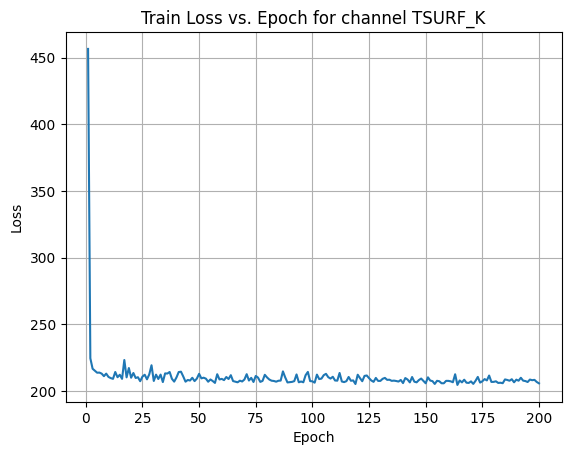

X Channel name :  SNOWEW_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 477.8135
Epoch [21/200] Loss: 206.5878
Epoch [41/200] Loss: 206.1653
Epoch [61/200] Loss: 207.9656
Epoch [81/200] Loss: 205.5611
Epoch [101/200] Loss: 207.2128
Epoch [121/200] Loss: 206.6283
Epoch [141/200] Loss: 211.2935
Epoch [161/200] Loss: 206.3016
Epoch [181/200] Loss: 205.3656
Average Test Loss: 193.2069


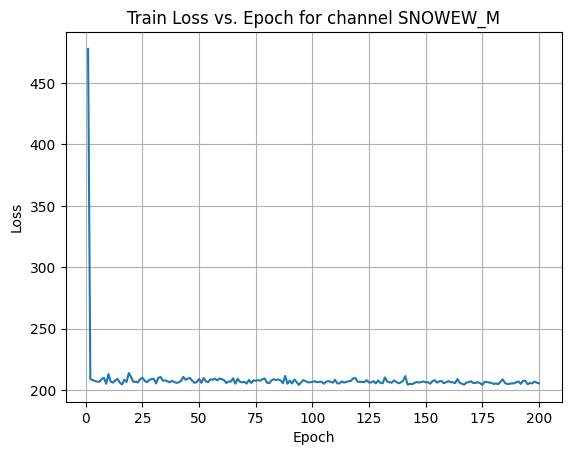

X Channel name :  SNOWAGE_HR
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 462.4369
Epoch [21/200] Loss: 210.2155
Epoch [41/200] Loss: 209.2710
Epoch [61/200] Loss: 208.4045
Epoch [81/200] Loss: 208.4854
Epoch [101/200] Loss: 205.9701
Epoch [121/200] Loss: 209.1967
Epoch [141/200] Loss: 207.1365
Epoch [161/200] Loss: 204.7594
Epoch [181/200] Loss: 205.6426
Average Test Loss: 192.1444


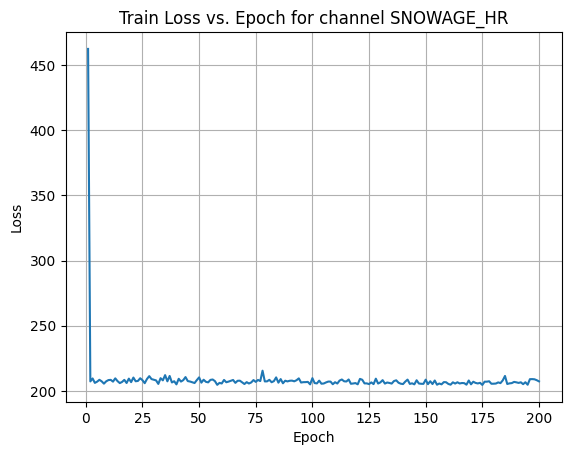

X Channel name :  PRATE_MMpH
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 472.0371
Epoch [21/200] Loss: 205.4417
Epoch [41/200] Loss: 211.9427
Epoch [61/200] Loss: 207.3585
Epoch [81/200] Loss: 207.0637
Epoch [101/200] Loss: 205.7639
Epoch [121/200] Loss: 208.2819
Epoch [141/200] Loss: 205.9290
Epoch [161/200] Loss: 206.4722
Epoch [181/200] Loss: 204.6692
Average Test Loss: 194.2285


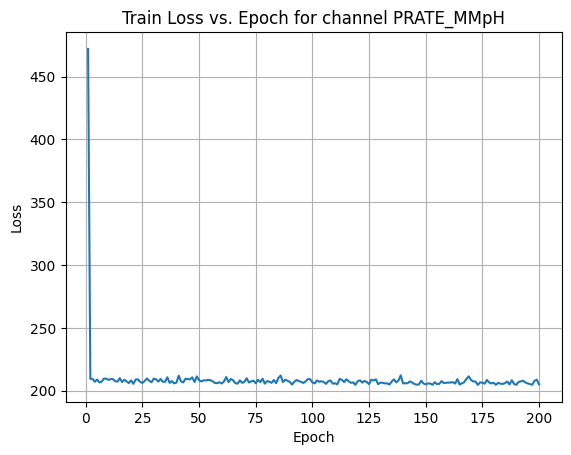

X Channel name :  CLOUD_OD
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 564.1714
Epoch [21/200] Loss: 344.2014
Epoch [41/200] Loss: 42.1575
Epoch [61/200] Loss: 8.7491
Epoch [81/200] Loss: 4.4118
Epoch [101/200] Loss: 3.6190
Epoch [121/200] Loss: 3.0569
Epoch [141/200] Loss: 61.7625
Epoch [161/200] Loss: 27.5137
Epoch [181/200] Loss: 24.1494
Average Test Loss: 9.5028


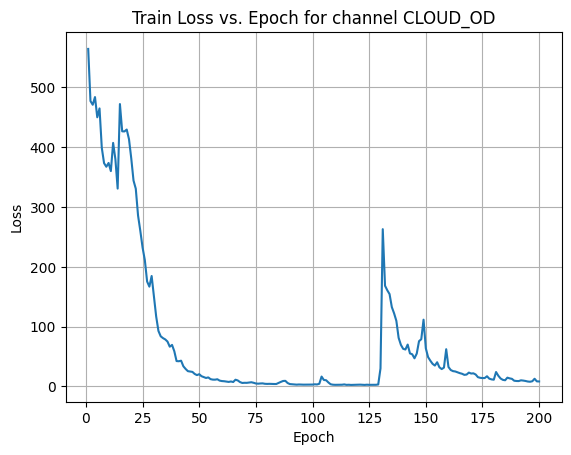

X Channel name :  U10_MpS
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 408.8093
Epoch [21/200] Loss: 44.8752
Epoch [41/200] Loss: 24.9497
Epoch [61/200] Loss: 13.9579
Epoch [81/200] Loss: 0.1622
Epoch [101/200] Loss: 6.6719
Epoch [121/200] Loss: 0.4896
Epoch [141/200] Loss: 0.5792
Epoch [161/200] Loss: 14.2761
Epoch [181/200] Loss: 70.1604
Average Test Loss: 12.3623


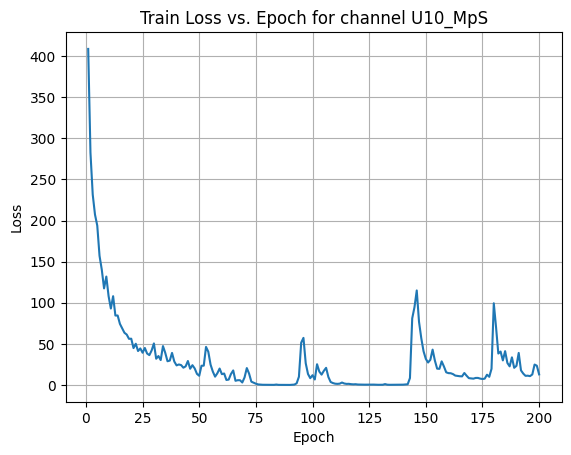

X Channel name :  V10_MpS
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 548.7915
Epoch [21/200] Loss: 3.2141
Epoch [41/200] Loss: 2.7785
Epoch [61/200] Loss: 0.0232
Epoch [81/200] Loss: 0.0948
Epoch [101/200] Loss: 0.0025
Epoch [121/200] Loss: 0.9383
Epoch [141/200] Loss: 0.0001
Epoch [161/200] Loss: 0.0294
Epoch [181/200] Loss: 0.1261
Average Test Loss: 9.7946


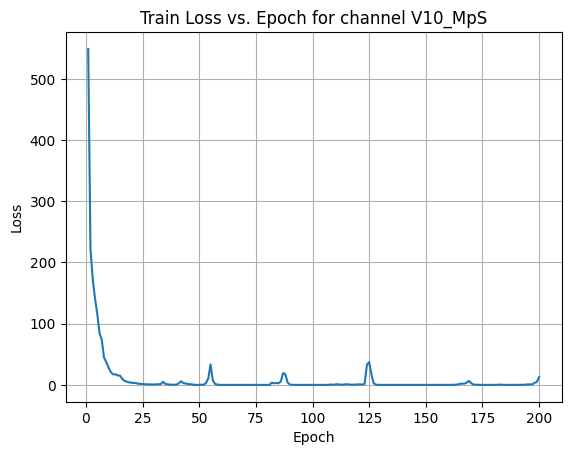

X Channel name :  T2_K
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 437.6390
Epoch [21/200] Loss: 211.8958
Epoch [41/200] Loss: 209.1216
Epoch [61/200] Loss: 206.8112
Epoch [81/200] Loss: 208.6605
Epoch [101/200] Loss: 209.3719
Epoch [121/200] Loss: 205.8712
Epoch [141/200] Loss: 205.6532
Epoch [161/200] Loss: 206.6720
Epoch [181/200] Loss: 210.9386
Average Test Loss: 194.6223


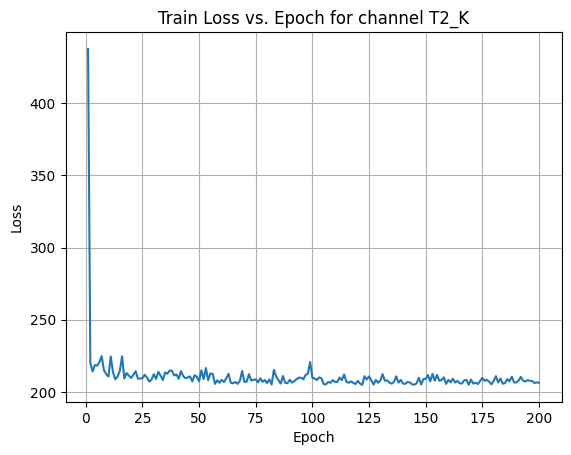

X Channel name :  SWSFC_WpM2
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 473.1083
Epoch [21/200] Loss: 209.1094
Epoch [41/200] Loss: 208.9790
Epoch [61/200] Loss: 208.6664
Epoch [81/200] Loss: 206.8456
Epoch [101/200] Loss: 205.0515
Epoch [121/200] Loss: 208.4971
Epoch [141/200] Loss: 206.8505
Epoch [161/200] Loss: 205.1185
Epoch [181/200] Loss: 205.4072
Average Test Loss: 190.4040


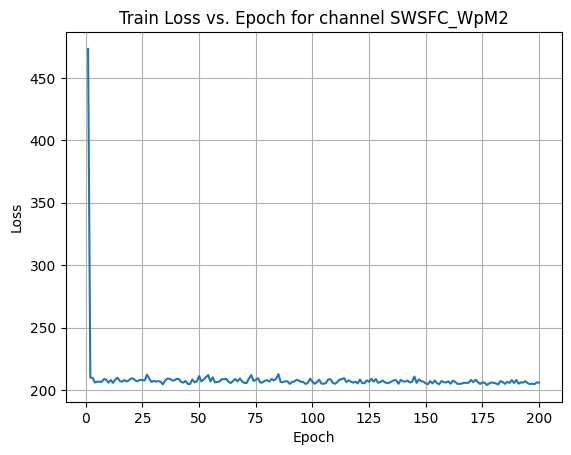

X Channel name :  SOLM_M3pM3
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 314.1800
Epoch [21/200] Loss: 172.8427
Epoch [41/200] Loss: 166.6741
Epoch [61/200] Loss: 146.4499
Epoch [81/200] Loss: 137.7754
Epoch [101/200] Loss: 124.5427
Epoch [121/200] Loss: 117.5214
Epoch [141/200] Loss: 80.4617
Epoch [161/200] Loss: 61.1875
Epoch [181/200] Loss: 58.7061
Average Test Loss: 48.6248


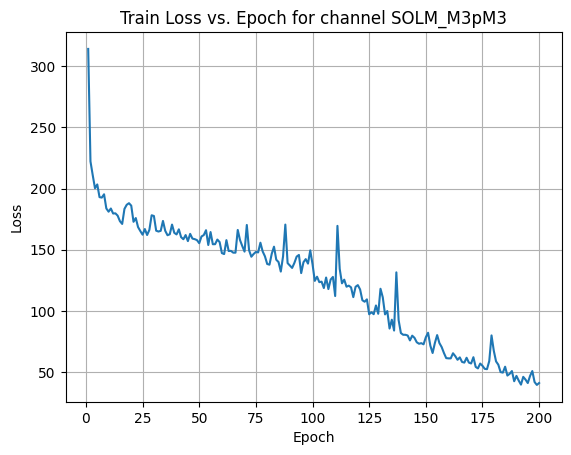

X Channel name :  CLDTOP_KM
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 459.2579
Epoch [21/200] Loss: 208.7148
Epoch [41/200] Loss: 205.7315
Epoch [61/200] Loss: 206.1591
Epoch [81/200] Loss: 204.8442
Epoch [101/200] Loss: 207.4638
Epoch [121/200] Loss: 205.2472
Epoch [141/200] Loss: 205.8601
Epoch [161/200] Loss: 206.6657
Epoch [181/200] Loss: 204.8562
Average Test Loss: 190.0712


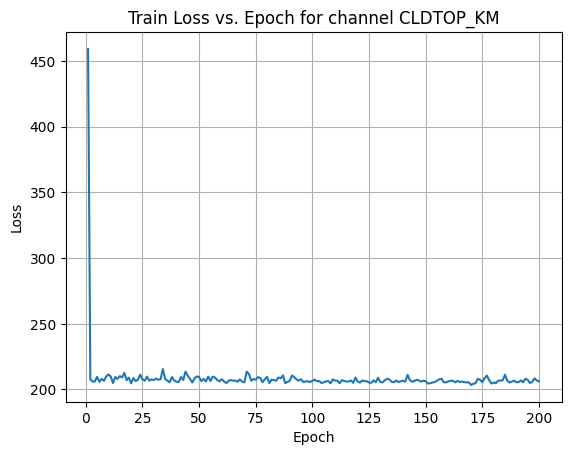

X Channel name :  CAPE
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 484.7886
Epoch [21/200] Loss: 212.4237
Epoch [41/200] Loss: 207.2098
Epoch [61/200] Loss: 206.3022
Epoch [81/200] Loss: 206.3118
Epoch [101/200] Loss: 204.9612
Epoch [121/200] Loss: 207.2573
Epoch [141/200] Loss: 204.7682
Epoch [161/200] Loss: 207.5781
Epoch [181/200] Loss: 206.0027
Average Test Loss: 190.4071


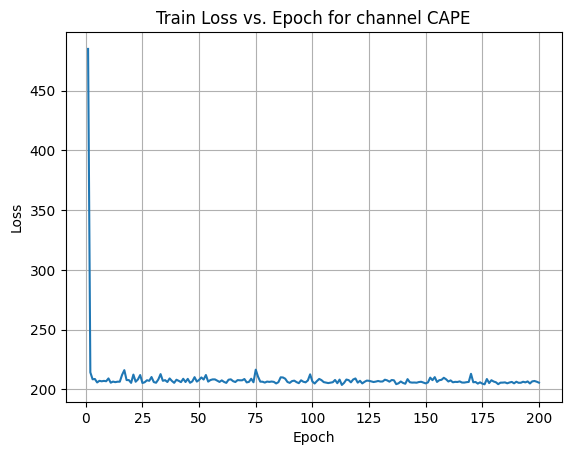

X Channel name :  PBL_WRF_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 293.7624
Epoch [21/200] Loss: 213.0560
Epoch [41/200] Loss: 207.0692
Epoch [61/200] Loss: 208.1894
Epoch [81/200] Loss: 206.1079
Epoch [101/200] Loss: 208.5100
Epoch [121/200] Loss: 206.7568
Epoch [141/200] Loss: 206.7352
Epoch [161/200] Loss: 206.3766
Epoch [181/200] Loss: 205.7095
Average Test Loss: 190.2207


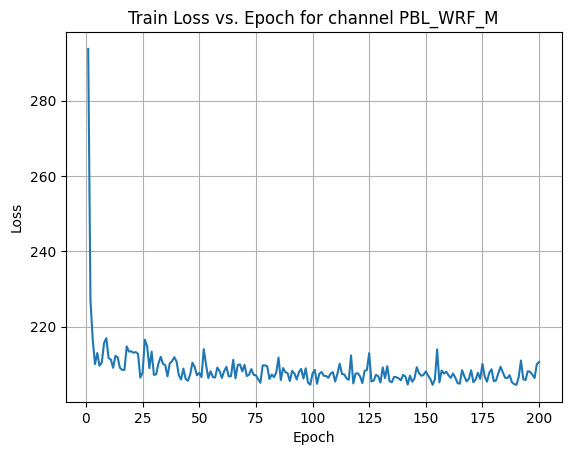

X Channel name :  PBL_YSU_M
Shapes:  (1324, 80, 80) (332, 80, 80) (1324, 80, 80) (332, 80, 80)
Epoch [1/200] Loss: 292.3670
Epoch [21/200] Loss: 209.4459
Epoch [41/200] Loss: 205.5247
Epoch [61/200] Loss: 209.8772
Epoch [81/200] Loss: 205.8432
Epoch [101/200] Loss: 207.1030
Epoch [121/200] Loss: 207.9024
Epoch [141/200] Loss: 208.0074
Epoch [161/200] Loss: 205.1104
Epoch [181/200] Loss: 205.0114
Average Test Loss: 193.2189


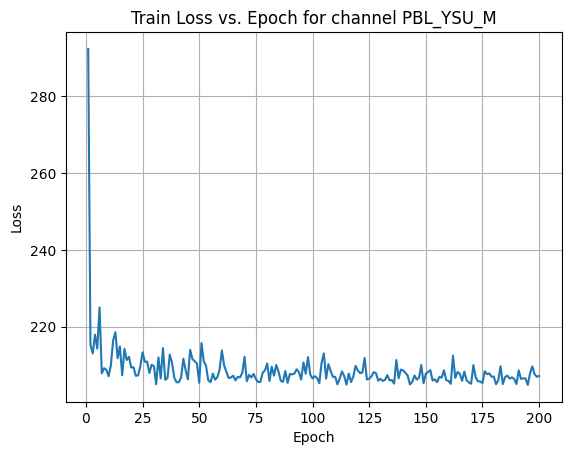

In [22]:
test_loss_list_P_25 = []
y_channel = 0 
# x_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print('X Channel name : ', target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel, :,:]
    X_test = X_test_all[:, x_channel, :,:]
    y_train = y_train_all[:, y_channel, :,:]
    y_test = y_test_all[:, y_channel, :,:]
    print('Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    ####################### Creating the dataset loader #######################
    train_custom_dataset = CustomDataset(X_train, y_train)
    # print(len(train_custom_dataset))
    batch_size = 32
    train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
    # print(len(train_loader))
    
    test_custom_dataset = CustomDataset(X_test, y_test)
    # print(len(test_custom_dataset))
    batch_size = 32
    test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
    # print(len(test_loader))
    

    #################### Training the model ####################
    model = Autoencoder_MLP()
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 200
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Print the average loss for this epoch
        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    
    ############################# testing the model #############################
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    # Print the average test loss
    average_test_loss = test_loss / len(test_loader)
    test_loss_list_P_25.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
    plt.grid(True) 
    plt.show() 

In [23]:
print(target_var_96_list)

['TSURF_K', 'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS', 'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE', 'PBL_WRF_M', 'PBL_YSU_M']


In [24]:
test_loss_list_P_25

[190.61658269708806,
 193.20687172629616,
 192.14442166415128,
 194.2284629128196,
 9.502846392718228,
 12.362347342751242,
 9.794623678380793,
 194.6223477450284,
 190.40404857288706,
 48.624787764115766,
 190.07123496315697,
 190.40707397460938,
 190.2206767689098,
 193.21893033114347]

In [25]:
name_loss_pairs = list(zip(target_var_96_list, test_loss_list_P_25))

# Sort based on loss values
sorted_name_loss_pairs = sorted(name_loss_pairs, key=lambda x: x[1])
for pair in sorted_name_loss_pairs:
    print(pair)
# print(sorted_name_loss_pairs)
# Select the lowest 3 names
lowest_3_names = [pair[0] for pair in sorted_name_loss_pairs[:3]]

print("Lowest 3 names:", lowest_3_names)

('CLOUD_OD', 9.502846392718228)
('V10_MpS', 9.794623678380793)
('U10_MpS', 12.362347342751242)
('SOLM_M3pM3', 48.624787764115766)
('CLDTOP_KM', 190.07123496315697)
('PBL_WRF_M', 190.2206767689098)
('SWSFC_WpM2', 190.40404857288706)
('CAPE', 190.40707397460938)
('TSURF_K', 190.61658269708806)
('SNOWAGE_HR', 192.14442166415128)
('SNOWEW_M', 193.20687172629616)
('PBL_YSU_M', 193.21893033114347)
('PRATE_MMpH', 194.2284629128196)
('T2_K', 194.6223477450284)
Lowest 3 names: ['CLOUD_OD', 'V10_MpS', 'U10_MpS']


# Autoencoder with convolutional layers

In [27]:
X.shape, y.shape # image_size = 80, input_channels = 14, output_dim = 80*80

((1656, 14, 80, 80), (1656, 2, 80, 80))

In [76]:
class Autoencoder_CNN(nn.Module):
    def __init__(self, image_size, num_input_channels, num_output_channels = 1,c_hid = 16, latent_dim = 1024, activation= nn.GELU):
        super(Autoencoder_CNN, self).__init__()
        self.image_size = image_size
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.c_hid = c_hid
        self.latent_dim = latent_dim
        self.activation = activation()
        # self.linear = nn.Linear(64 * 10 * 10, 1024) #nn.Linear(64 * image_size//16 * image_size//16, 1024)

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=self.num_input_channels, out_channels=self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation,
            nn.Conv2d(in_channels=self.c_hid, out_channels=self.c_hid, kernel_size=3, padding=1),
            self.activation,
            nn.Conv2d(in_channels=self.c_hid, out_channels=2 * self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation,
            nn.Conv2d(in_channels=2 * self.c_hid, out_channels=2 * self.c_hid, kernel_size=3, padding=1),
            self.activation,
            nn.Conv2d(in_channels=2 * self.c_hid, out_channels=4*self.c_hid, kernel_size=3, stride=2, padding=1),
            self.activation,
            nn.Flatten(),
            nn.Linear((4 * self.c_hid) * self.image_size//8 * self.image_size//8, self.latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, (4 * self.c_hid) * self.image_size//8 * self.image_size//8),
            nn.Unflatten(1, (4*self.c_hid, self.image_size//8, self.image_size//8)),
            nn.ConvTranspose2d(in_channels=4*self.c_hid, out_channels= 2*self.c_hid, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.activation,
            nn.Conv2d(in_channels = 2*self.c_hid, out_channels= 2*self.c_hid, kernel_size=3, padding=1),
            self.activation,
            nn.ConvTranspose2d(in_channels = 2*self.c_hid, out_channels = self.c_hid, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.activation,
            nn.Conv2d(in_channels = self.c_hid,out_channels= self.c_hid, kernel_size=3, padding=1),
            self.activation,
            nn.ConvTranspose2d(in_channels = self.c_hid, out_channels= self.num_output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
        
    # def encoder(self, x):
    #     # print(x.shape)
    #     x = nn.Conv2d(in_channels=self.num_input_channels, out_channels=self.c_hid, kernel_size=3, stride=2, padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)
    #     x = nn.Conv2d(in_channels=self.c_hid, out_channels=self.c_hid, kernel_size=3, padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)
    #     x =  nn.Conv2d(in_channels=self.c_hid, out_channels=2 * self.c_hid, kernel_size=3, stride=2, padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)
    #     x = nn.Conv2d(in_channels=2 * self.c_hid, out_channels=2 * self.c_hid, kernel_size=3, padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)        
    #     x = nn.Conv2d(in_channels=2 * self.c_hid, out_channels=4*self.c_hid, kernel_size=3, stride=2, padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)
    #     x = nn.Flatten()(x)
    #     # print(x.shape)
    #     x = nn.Linear((4 * self.c_hid) * self.image_size//8 * self.image_size//8, self.latent_dim)(x) # (64*10*10, 1024)
    #     return x
    
    # def decoder(self, x):
    #     # print('in decoder')
    #     # print(x.shape)
    #     x = nn.Linear(self.latent_dim, (4 * self.c_hid) * self.image_size//8 * self.image_size//8)(x)
    #     # print(x.shape)
    #     x = x.reshape(x.shape[0], -1, self.image_size//8, self.image_size//8)
    #     # print(x.shape)
    #     x = nn.ConvTranspose2d(in_channels=4*self.c_hid, out_channels= 2*self.c_hid, kernel_size=3, stride=2, padding=1, output_padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)
    #     x = nn.Conv2d(in_channels = 2*self.c_hid, out_channels= 2*self.c_hid, kernel_size=3, padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)
    #     x = nn.ConvTranspose2d(in_channels = 2*self.c_hid, out_channels = self.c_hid, kernel_size=3, stride=2, padding=1, output_padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)
    #     x = nn.Conv2d(in_channels = self.c_hid,out_channels= self.c_hid, kernel_size=3, padding=1)(x)
    #     # print(x.shape)
    #     x = self.activation(x)
    #     x = nn.ConvTranspose2d(in_channels = self.c_hid, out_channels= self.num_output_channels, kernel_size=3, stride=2, padding=1, output_padding=1)(x)
    #     # print(x.shape)
    #     x = nn.Tanh()(x)
    #     # print(x.shape)
    #     return x
    
    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        return x
model_auto = Autoencoder_CNN(image_size = 80, num_input_channels = 14, num_output_channels=2, c_hid = 16, latent_dim = 1024, activation= nn.GELU)
model_auto
dummy_input = torch.randn(11, 14, 80, 80)  # Assuming input size of (batch_size, num_num_input_channels, height, width)
out = model_auto(dummy_input)
print(out.shape)

torch.Size([11, 2, 80, 80])


In [77]:
print(X.shape, y.shape)
out = model_auto(torch.tensor(X))
print(out.shape)

(1656, 14, 80, 80) (1656, 2, 80, 80)


torch.Size([1656, 2, 80, 80])


In [78]:
print(list(model_auto.parameters()))

[Parameter containing:
tensor([[[[ 7.3284e-02, -1.7039e-02, -6.8802e-02],
          [-2.0377e-02,  2.5549e-02, -4.5991e-02],
          [-7.1585e-02, -2.1510e-02, -3.2533e-02]],

         [[ 1.5010e-02,  4.0003e-02, -8.8191e-02],
          [-6.2555e-02,  4.8093e-02, -6.6184e-02],
          [-2.1823e-02,  7.9852e-03,  1.9856e-02]],

         [[ 4.2693e-02, -8.0556e-02,  3.2001e-02],
          [-5.1848e-02, -3.3127e-02, -5.4586e-02],
          [-8.9022e-02, -6.2112e-02,  4.1477e-02]],

         ...,

         [[ 3.0448e-02,  8.3138e-02,  3.3080e-02],
          [-4.8114e-02,  2.7233e-02, -7.5769e-02],
          [ 3.9763e-02,  2.0680e-02, -1.8875e-02]],

         [[ 4.5761e-02,  5.2045e-02, -1.0835e-02],
          [-2.6358e-02, -2.1957e-02, -5.7168e-02],
          [ 2.3490e-02, -2.8469e-02,  6.6693e-02]],

         [[-3.8574e-02, -6.1382e-02, -5.0233e-02],
          [-6.4050e-02,  2.2143e-02,  7.2771e-03],
          [-4.8420e-02,  5.5444e-02, -5.6173e-02]]],


        [[[ 4.1304e-02, -7.133

In [79]:
print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)
train_custom_dataset = CustomDataset(X_train_all, y_train_all)
# print(len(train_custom_dataset))
batch_size = 32
train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
# print(len(train_loader))

test_custom_dataset = CustomDataset(X_test_all, y_test_all)
# print(len(test_custom_dataset))
batch_size = 32
test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
# print(len(test_loader))


(1324, 14, 80, 80) (332, 14, 80, 80) (1324, 2, 80, 80) (332, 2, 80, 80)


In [80]:


#################### Training the model ####################
model = Autoencoder_CNN(image_size = 80, num_input_channels = 14, num_output_channels=2, c_hid = 16, latent_dim = 1024, activation= nn.GELU)
model.to(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Print the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    if epoch % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")


Epoch [1/200] Loss: 1156.4948
Epoch [21/200] Loss: 1135.6863
Epoch [41/200] Loss: 1140.3182
Epoch [61/200] Loss: 1138.6552
Epoch [81/200] Loss: 1143.7346
Epoch [101/200] Loss: 1137.2062
Epoch [121/200] Loss: 1137.8223
Epoch [141/200] Loss: 1141.3736
Epoch [161/200] Loss: 1141.1446


KeyboardInterrupt: 

In [ ]:

############################# testing the model #############################
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(test_loader)
test_loss_list_P_25.append(average_test_loss)
print(f"Average Test Loss: {average_test_loss:.4f}")

plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
plt.grid(True) 
plt.show() 